## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import joblib
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create models directory if it doesn't exist
Path("../models/supervised").mkdir(parents=True, exist_ok=True)
Path("../models/unsupervised").mkdir(parents=True, exist_ok=True)
Path("../models/preprocessing").mkdir(parents=True, exist_ok=True)


## Data Loading and Initial Exploration

In [2]:
# Data validation utilities
def validate_dataframe(df, name="DataFrame"):
    """Validate DataFrame quality and report statistics."""
    print(f"\n{'='*50}")
    print(f"Validation: {name}")
    print(f"{'='*50}")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    print(f"Data types: {df.dtypes.value_counts().to_dict()}")
    
    if df.select_dtypes(include=[np.number]).shape[1] > 0:
        numeric_df = df.select_dtypes(include=[np.number])
        print(f"Numeric columns: {numeric_df.shape[1]}")
        print(f"  - Mean range: [{numeric_df.mean().min():.2e}, {numeric_df.mean().max():.2e}]")
        print(f"  - Std range: [{numeric_df.std().min():.2e}, {numeric_df.std().max():.2e}]")
    
    print(f"{'='*50}\n")
    return df

def check_class_balance(y, label_name="Labels"):
    """Check and report class distribution."""
    counts = y.value_counts()
    print(f"\n{label_name} distribution:")
    for label, count in counts.items():
        percentage = (count / len(y)) * 100
        print(f"  {label}: {count} ({percentage:.1f}%)")
    
    # Check for severe imbalance
    if len(counts) > 1:
        ratio = counts.max() / counts.min()
        if ratio > 3:
            print(f"⚠ Warning: Class imbalance detected (ratio {ratio:.1f}:1)")
    return counts


In [3]:
# Use relative path from notebooks/ to data/
file_path = Path("../data/GSE19804_series_matrix.txt")

# Check if file exists
if not file_path.exists():
    print(f"Error: File not found at {file_path}")
    print(f"Please ensure the data file is in the data/ directory")
    sys.exit(1)

# Lire les lignes utiles
try:
    with open(file_path, 'rt') as f:
        lines = f.readlines()
except Exception as e:
    print(f"Error reading file: {e}")
    sys.exit(1)

# Identify start and end lines of the data matrix
start = None
end = None
for i, line in enumerate(lines):
    if line.startswith("!series_matrix_table_begin"):  # start of our matrix
        start = i + 1  # ignore metadata line
    elif line.startswith("!series_matrix_table_end"):  # end of our matrix
        end = i
        break

if start is None or end is None:
    print("Error: Could not find data matrix markers in file")
    sys.exit(1)

# read the data matrix
df = pd.read_csv(file_path, sep="\t", skiprows=start, nrows=end - start - 1, index_col=0, comment="!")
print(f"✓ Data loaded successfully: {df.shape[0]} genes, {df.shape[1]} samples")
df.head()


✓ Data loaded successfully: 54675 genes, 120 samples


,GSM494556,GSM494557,GSM494558,GSM494559,GSM494560,GSM494561,GSM494562,GSM494563,GSM494564,GSM494565,...,GSM494666,GSM494667,GSM494668,GSM494669,GSM494670,GSM494671,GSM494672,GSM494673,GSM494674,GSM494675
ID_REF,,,,,,,,,,,,,,,,,,,,,
1007_s_at,11.96280,11.38780,11.19280,11.90360,11.75230,11.04240,10.74160,11.71090,11.46260,11.49050,...,10.35930,10.55280,10.81930,10.97170,10.38300,10.60120,11.19790,10.84320,10.60670,9.37942
1053_at,7.05652,7.33711,7.26121,7.91211,8.27448,7.60698,9.80415,8.85862,7.80342,8.43741,...,7.69447,7.80456,7.87718,7.64986,7.80042,7.92790,7.85849,7.91834,8.05853,7.51433
117_at,6.55585,6.96023,7.14488,7.13887,7.72479,8.01441,8.88544,7.99740,7.33263,10.54530,...,7.44120,7.82203,8.46291,7.68880,9.54127,8.62987,7.88748,7.85222,7.24397,8.83099
121_at,8.43850,8.51636,8.43138,8.67404,8.78145,8.55224,8.86868,8.15469,8.72485,8.13286,...,8.33440,8.18781,8.46548,8.23930,8.60798,8.59521,8.66340,8.33596,8.66742,8.46711
1255_g_at,3.73169,3.77978,3.99853,3.69171,3.93509,3.54508,4.14981,6.99991,4.38131,4.05949,...,3.73375,3.59215,3.74585,3.73324,3.65606,3.71172,3.84361,3.75038,3.87179,3.71853


In [4]:
print(f"Shape: {df.shape}")
print(f"Samples: {df.columns[:5]}")

# Remove columns with missing names
df = df.loc[:, df.columns.notna()]
print(f"✓ Removed columns with missing names: {df.shape}")

# Remove duplicate gene rows
df = df[~df.index.duplicated(keep='first')]
print(f"✓ Removed duplicate genes: {df.shape}")

# Convert all values to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Check for missing values
missing_count = df.isnull().sum().sum()
print(f"⚠ Missing values found: {missing_count}")

if missing_count > 0:
    # Count missing per row and column
    missing_per_row = df.isnull().sum(axis=1)
    missing_per_col = df.isnull().sum(axis=0)
    print(f"  - Genes with missing values: {(missing_per_row > 0).sum()}")
    print(f"  - Samples with missing values: {(missing_per_col > 0).sum()}")


Shape: (54675, 120)
Samples: Index(['GSM494556', 'GSM494557', 'GSM494558', 'GSM494559', 'GSM494560'], dtype='object')
✓ Removed columns with missing names: (54675, 120)
✓ Removed duplicate genes: (54675, 120)
⚠ Missing values found: 0


In [5]:
# Strategy: Remove genes (rows) with any missing values
# Keep all samples (columns) since they're our observations
df_clean = df.dropna(axis=0)  # axis=0 removes rows (genes) with NaN
print(f"✓ Removed genes with missing values: {df.shape[0]} → {df_clean.shape[0]} genes")

# Remove genes (columns after transpose) with all zeros (no expression)
df_clean = df_clean.loc[:, (df_clean != 0).any(axis=0)]
print(f"✓ Removed zero-expression genes: {df_clean.shape}")

# Transpose: samples as rows, genes as columns
df_T = df_clean.T
print(f"✓ Transposed data: {df_T.shape[0]} samples × {df_T.shape[1]} genes")

# Standardize features (Z-score normalization)
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_T), 
    index=df_T.index, 
    columns=df_T.columns
)

# Verify cleaning
print(f"\n✓ Final cleaned data: {df_scaled.shape}")
print(f"✓ Missing values: {df_scaled.isnull().sum().sum()}")
print(f"✓ Mean: {df_scaled.mean().mean():.2e} (should be ~0)")
print(f"✓ Std: {df_scaled.std().mean():.2f} (should be ~1)")

# Save scaler and feature names for later use
scaler_path = Path("../models/preprocessing/scaler.pkl")
features_path = Path("../models/preprocessing/feature_names.pkl")

joblib.dump(scaler, scaler_path)
joblib.dump(list(df_scaled.columns), features_path)
print(f"\n✓ Saved scaler to {scaler_path}")
print(f"✓ Saved feature names to {features_path}")


✓ Removed genes with missing values: 54675 → 54675 genes
✓ Removed zero-expression genes: (54675, 120)
✓ Transposed data: 120 samples × 54675 genes

✓ Final cleaned data: (120, 54675)
✓ Missing values: 0
✓ Mean: -1.09e-16 (should be ~0)
✓ Std: 1.00 (should be ~1)

✓ Saved scaler to ..\models\preprocessing\scaler.pkl
✓ Saved feature names to ..\models\preprocessing\feature_names.pkl

✓ Final cleaned data: (120, 54675)
✓ Missing values: 0
✓ Mean: -1.09e-16 (should be ~0)
✓ Std: 1.00 (should be ~1)

✓ Saved scaler to ..\models\preprocessing\scaler.pkl
✓ Saved feature names to ..\models\preprocessing\feature_names.pkl


In [6]:
# Reduced to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {explained_var[0]:.2%}")
print(f"Variance explained by PC2: {explained_var[1]:.2%}")
print(f"Total variance explained: {explained_var.sum():.2%}")

# Store the projection with samples index
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_scaled.index)
print(f"\n✓ PCA projection: {df_pca.shape}")

# Save PCA transformer
pca_path = Path("../models/preprocessing/pca_transformer.pkl")
joblib.dump(pca, pca_path)
print(f"✓ Saved PCA transformer to {pca_path}")


Variance explained by PC1: 16.07%
Variance explained by PC2: 11.06%
Total variance explained: 27.13%

✓ PCA projection: (120, 2)
✓ Saved PCA transformer to ..\models\preprocessing\pca_transformer.pkl


## Anomaly Detection with Isolation Forest

In [7]:
# Initialize Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Train the model on standardized data
iso_forest.fit(df_scaled)

# Predict anomalies: -1 = anomaly, 1 = normal
df_pca['Anomaly_IF'] = iso_forest.predict(df_scaled)

# Save model
if_path = Path("../models/unsupervised/isolation_forest.pkl")
joblib.dump(iso_forest, if_path)
print(f"✓ Saved Isolation Forest model to {if_path}")


✓ Saved Isolation Forest model to ..\models\unsupervised\isolation_forest.pkl


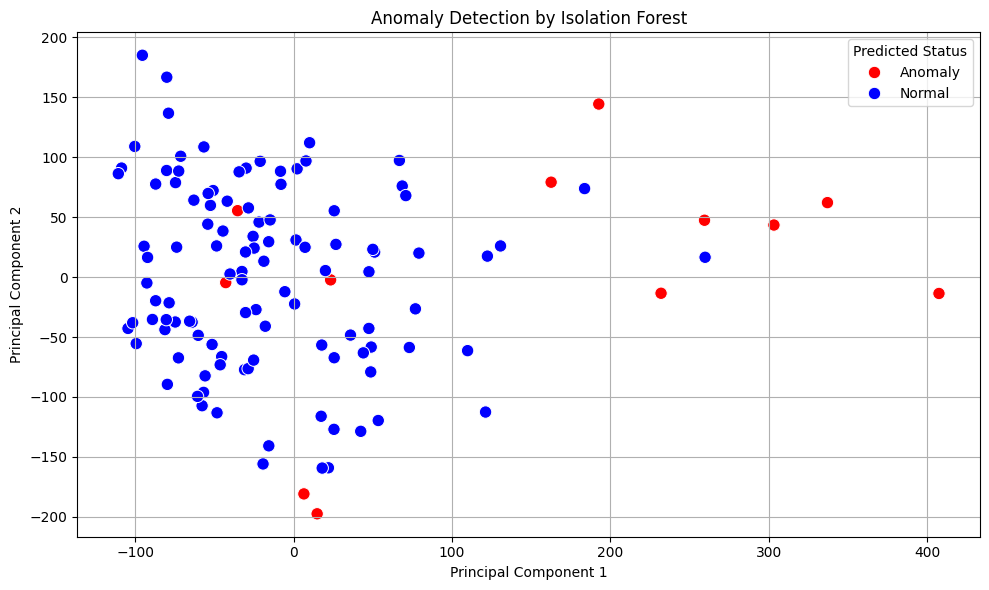

In [8]:
# Create a new text column for display
df_pca['Anomaly_Label'] = df_pca['Anomaly_IF'].map({1: "Normal", -1: "Anomaly"})

# Use this column for color
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,  # DataFrame with principal components and anomaly labels
    x='PC1', y='PC2',  # Principal components for axes
    hue='Anomaly_Label',  # Color based on anomaly label
    palette={"Normal": "blue", "Anomaly": "red"},  # Color palette for labels
    s=80  # Point size
)

plt.title("Anomaly Detection by Isolation Forest")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Predicted Status")
plt.grid(True)
plt.tight_layout()
plt.show()


## Anomaly Detection with Autoencoder

In [9]:
# Build autoencoder architecture
n_features = df_scaled.shape[1]

input_layer = Input(shape=(n_features,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
output_layer = Dense(n_features, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print(f"Autoencoder architecture: {n_features} → 64 → 32 → 64 → {n_features}")

# Train autoencoder
history = autoencoder.fit(
    df_scaled, df_scaled,
    epochs=50,
    batch_size=16,
    shuffle=True,
    validation_split=0.1,
    verbose=0
)

print(f"✓ Autoencoder training completed")
print(f"  Final loss: {history.history['loss'][-1]:.4f}")
print(f"  Final val_loss: {history.history['val_loss'][-1]:.4f}")

# Save autoencoder model
ae_path = Path("../models/unsupervised/autoencoder.h5")
autoencoder.save(ae_path)
print(f"✓ Saved Autoencoder model to {ae_path}")


Autoencoder architecture: 54675 → 64 → 32 → 64 → 54675


✓ Autoencoder training completed
  Final loss: 0.2170
  Final val_loss: 0.6147
✓ Saved Autoencoder model to ..\models\unsupervised\autoencoder.h5


In [10]:
# Reconstruction
reconstructed = autoencoder.predict(df_scaled)
# Mean squared error per sample
reconstruction_error = np.mean(np.square(df_scaled - reconstructed), axis=1)
# Add to PCA DataFrame
df_pca['Reconstruction_Error'] = reconstruction_error


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [11]:
# Reconstruct df_pca with aligned index
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_scaled.index)

# Add reconstruction error
df_pca['Reconstruction_Error'] = reconstruction_error

# Add Isolation Forest predictions
df_pca['Anomaly_IF'] = iso_forest.predict(df_scaled).astype(int)

# AE detection: threshold based on 90th percentile
threshold = np.percentile(reconstruction_error, 90)

# Anomaly detection: -1 = anomaly, 1 = normal
df_pca['Anomaly_AE'] = (df_pca['Reconstruction_Error'] > threshold).astype(int)
df_pca['Anomaly_AE'] = df_pca['Anomaly_AE'].map({0: 1, 1: -1})  # align with Isolation Forest

# Add readable label
df_pca['AE_Label'] = df_pca['Anomaly_AE'].map({1: "Normal", -1: "Anomaly"})


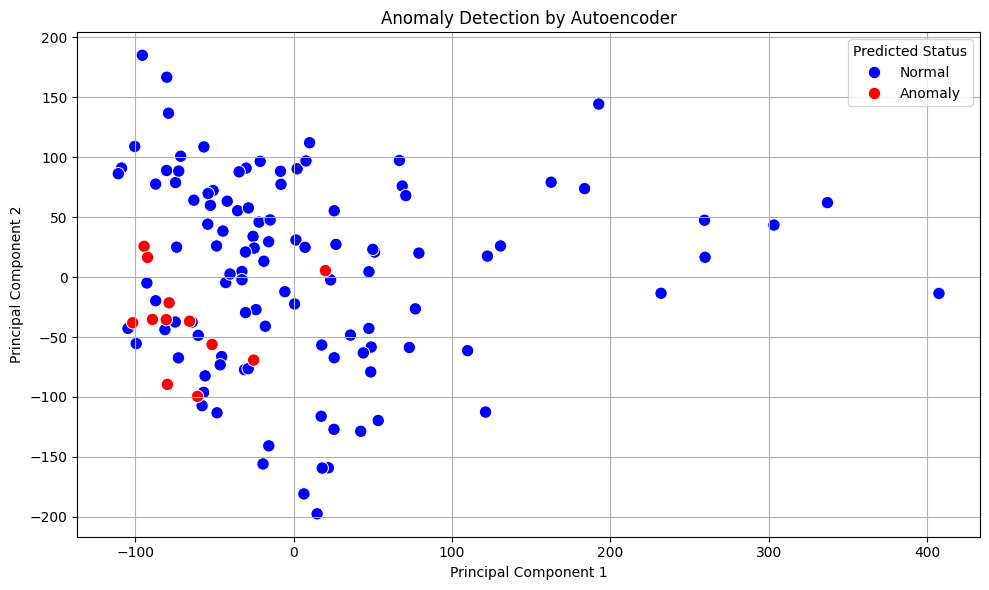

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='AE_Label',
    palette={"Normal": "blue", "Anomaly": "red"},
    s=80
)

plt.title("Anomaly Detection by Autoencoder")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Predicted Status")
plt.grid(True)
plt.tight_layout()
plt.show()


## Anomaly Detection with Local Outlier Factor (LOF)

In [13]:
# Initialize LOF model
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.1,
    novelty=False  # fit_predict mode only
)

# Predict anomalies directly (LOF doesn't have separate fit/predict)
lof_preds = lof.fit_predict(df_scaled)  # -1 = anomaly, 1 = normal

# Add to PCA dataframe
df_pca['Anomaly_LOF'] = lof_preds 
df_pca['LOF_Label'] = df_pca['Anomaly_LOF'].map({1: "Normal", -1: "Anomaly"})

print(f"✓ LOF predictions completed")

# Note: LOF with novelty=False cannot be saved for prediction on new data
# For deployment, use novelty=True and retrain
print("⚠ LOF model not saved (novelty=False mode cannot predict on new data)")


✓ LOF predictions completed
⚠ LOF model not saved (novelty=False mode cannot predict on new data)


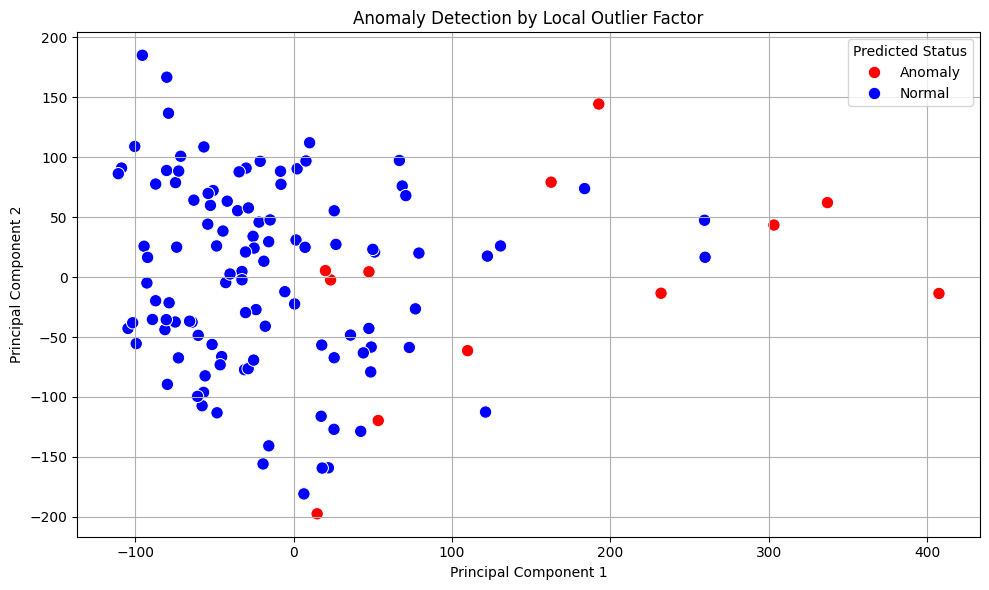

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='LOF_Label',
    palette={"Normal": "blue", "Anomaly": "red"},
    s=80
)

plt.title("Anomaly Detection by Local Outlier Factor")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Predicted Status")
plt.grid(True)
plt.tight_layout()
plt.show()


## Model Comparison Against Ground Truth

In [15]:
# Extract sample metadata from original file
sample_ids = []
sample_labels = []

# Extract sample IDs
for line in lines:
    if line.startswith("!Sample_geo_accession"):
        sample_ids = [x.replace('"', '').strip() for x in line.strip().split("\t")[1:]]
        break

if not sample_ids:
    print("⚠ Warning: No sample IDs found in file")

# Extract sample labels from titles
for line in lines:
    if line.startswith("!Sample_title"):
        titles = line.strip().split("\t")[1:]
        for title in titles:
            t = title.lower()
            if "normal" in t:
                sample_labels.append("Healthy")
            elif "cancer" in t or "tumor" in t:
                sample_labels.append("Cancer")
            else:
                sample_labels.append("Unknown")
        break

if not sample_labels:
    print("⚠ Warning: No sample labels found in file")
elif len(sample_ids) != len(sample_labels):
    print(f"⚠ Warning: Mismatch between IDs ({len(sample_ids)}) and labels ({len(sample_labels)})")

# Create mapping dictionary
sample_status = dict(zip(sample_ids, sample_labels))

# Map labels to dataframe
df_pca['Label'] = df_pca.index.map(sample_status)

# Check for unmapped samples
unmapped = df_pca['Label'].isna().sum()
if unmapped > 0:
    print(f"⚠ Warning: {unmapped} samples could not be mapped to labels")

# Display distribution
print("\n✓ Sample label distribution:")
print(df_pca['Label'].value_counts(dropna=False))



✓ Sample label distribution:
Label
Cancer     60
Healthy    60
Name: count, dtype: int64


In [16]:
def evaluate_model(anomaly_col, model_name):
    """Evaluate unsupervised anomaly detection model against true labels."""
    print(f"\n{'='*60}")
    print(f"Evaluation: {model_name}")
    print(f"{'='*60}")
    
    # Prepare evaluation dataframe
    df_eval = df_pca[['Label', anomaly_col]].copy()
    
    # Clean and standardize labels
    df_eval['Label_clean'] = df_eval['Label'].astype(str).str.lower().str.strip()
    df_eval['Label_clean'] = df_eval['Label_clean'].replace({
        'cancer': 'Cancer',
        'normal': 'Healthy', 
        'tumor': 'Cancer',
        'healthy': 'Healthy'
    })
    
    # Filter valid data only
    data = df_eval[df_eval['Label_clean'].isin(['Cancer', 'Healthy'])].copy()
    
    if data.empty:
        print("⚠ No usable data for evaluation")
        return None
    
    print(f"Evaluating on {len(data)} samples")
    
    # Convert to binary: 1 = Cancer, 0 = Healthy
    y_true = data['Label_clean'].map({'Cancer': 1, 'Healthy': 0})
    y_pred = data[anomaly_col].map({-1: 1, 1: 0})  # -1 (anomaly) = Cancer
    
    # Check for conversion issues
    if y_pred.isna().any():
        print(f"⚠ Warning: {y_pred.isna().sum()} predictions could not be converted")
    
    try:
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print("\nConfusion Matrix:")
        print(cm)
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=["Healthy", "Cancer"], zero_division=0))
        
        return {'confusion_matrix': cm, 'y_true': y_true, 'y_pred': y_pred}
        
    except Exception as e:
        print(f"✗ Error during evaluation: {e}")
        return None

# Note: Call this function for each model
# Example: evaluate_model('Anomaly_IF', 'Isolation Forest')


In [17]:
evaluate_model('Anomaly_IF', 'Isolation Forest')  # Evaluate Isolation Forest model



Evaluation: Isolation Forest
Evaluating on 120 samples

Confusion Matrix:
[[58  2]
 [50 10]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.54      0.97      0.69        60
      Cancer       0.83      0.17      0.28        60

    accuracy                           0.57       120
   macro avg       0.69      0.57      0.48       120
weighted avg       0.69      0.57      0.48       120



{'confusion_matrix': array([[58,  2],
        [50, 10]]),
 'y_true': GSM494556    1
 GSM494557    1
 GSM494558    1
 GSM494559    1
 GSM494560    1
             ..
 GSM494671    0
 GSM494672    0
 GSM494673    0
 GSM494674    0
 GSM494675    0
 Name: Label_clean, Length: 120, dtype: int64,
 'y_pred': GSM494556    1
 GSM494557    0
 GSM494558    0
 GSM494559    0
 GSM494560    0
             ..
 GSM494671    0
 GSM494672    0
 GSM494673    0
 GSM494674    0
 GSM494675    0
 Name: Anomaly_IF, Length: 120, dtype: int64}

In [18]:
evaluate_model('Anomaly_AE', 'Autoencoder')  # Evaluate Autoencoder model



Evaluation: Autoencoder
Evaluating on 120 samples

Confusion Matrix:
[[48 12]
 [60  0]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.44      0.80      0.57        60
      Cancer       0.00      0.00      0.00        60

    accuracy                           0.40       120
   macro avg       0.22      0.40      0.29       120
weighted avg       0.22      0.40      0.29       120



{'confusion_matrix': array([[48, 12],
        [60,  0]]),
 'y_true': GSM494556    1
 GSM494557    1
 GSM494558    1
 GSM494559    1
 GSM494560    1
             ..
 GSM494671    0
 GSM494672    0
 GSM494673    0
 GSM494674    0
 GSM494675    0
 Name: Label_clean, Length: 120, dtype: int64,
 'y_pred': GSM494556    0
 GSM494557    0
 GSM494558    0
 GSM494559    0
 GSM494560    0
             ..
 GSM494671    1
 GSM494672    1
 GSM494673    1
 GSM494674    1
 GSM494675    1
 Name: Anomaly_AE, Length: 120, dtype: int64}

In [19]:
evaluate_model('Anomaly_LOF', 'Local Outlier Factor')  # Evaluate Local Outlier Factor model



Evaluation: Local Outlier Factor
Evaluating on 120 samples

Confusion Matrix:
[[56  4]
 [52  8]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.52      0.93      0.67        60
      Cancer       0.67      0.13      0.22        60

    accuracy                           0.53       120
   macro avg       0.59      0.53      0.44       120
weighted avg       0.59      0.53      0.44       120



{'confusion_matrix': array([[56,  4],
        [52,  8]]),
 'y_true': GSM494556    1
 GSM494557    1
 GSM494558    1
 GSM494559    1
 GSM494560    1
             ..
 GSM494671    0
 GSM494672    0
 GSM494673    0
 GSM494674    0
 GSM494675    0
 Name: Label_clean, Length: 120, dtype: int64,
 'y_pred': GSM494556    1
 GSM494557    0
 GSM494558    0
 GSM494559    0
 GSM494560    0
             ..
 GSM494671    0
 GSM494672    0
 GSM494673    0
 GSM494674    0
 GSM494675    1
 Name: Anomaly_LOF, Length: 120, dtype: int64}

| Model                | Accuracy | Recall Cancer | Precision Cancer | F1-score Cancer |
| -------------------- | -------- | ------------- | ---------------- | --------------- |
| **Isolation Forest** | 57%      | 17%           | 83%              | 28%             |
| **Autoencoder**      | 42%      | **2%**        | **8%**           | **3%**          |
| **LOF**              | **53%**  | **13%**       | 67%              | **22%**         |


## Supervised Learning Pipeline

### Data Preparation for Classification

In [20]:
# Prepare data for supervised learning
X = df_scaled.copy()

# Extract and clean labels
y = df_pca['Label'].astype(str).str.lower().str.strip()
y = y.replace({'cancer': 1, 'healthy': 0, 'normal': 0})

# Remove samples with unknown labels
valid_mask = y.isin([0, 1])
X = X[valid_mask]
y = y[valid_mask].astype(int)

print(f"✓ Prepared supervised learning data:")
print(f"  - Features: {X.shape}")
print(f"  - Labels: {len(y)}")

# Check class balance
check_class_balance(y, "Class distribution")


✓ Prepared supervised learning data:
  - Features: (120, 54675)
  - Labels: 120

Class distribution distribution:
  1: 60 (50.0%)
  0: 60 (50.0%)


Label
1    60
0    60
Name: count, dtype: int64

In [21]:
# Train/test split with stratification
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    print("✓ Train/test split successful:")
    print(f"  - Training set: {X_train.shape[0]} samples")
    print(f"  - Test set: {X_test.shape[0]} samples")
    
    print("\n  Training set distribution:")
    check_class_balance(y_train, "Train")
    
    print("\n  Test set distribution:")
    check_class_balance(y_test, "Test")
    
except ValueError as e:
    print(f"✗ Error during train/test split: {e}")
    print("This may happen if one class has too few samples for stratification")


✓ Train/test split successful:
  - Training set: 96 samples
  - Test set: 24 samples

  Training set distribution:

Train distribution:
  1: 48 (50.0%)
  0: 48 (50.0%)

  Test set distribution:

Test distribution:
  1: 12 (50.0%)
  0: 12 (50.0%)


In [22]:
# Train SVM model
print("Training SVM (Linear Kernel)...")

try:
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_svm = svm_model.predict(X_test)
    
    print("✓ SVM training completed")
    
    # Save model
    svm_path = Path("../models/supervised/svm_model.pkl")
    joblib.dump(svm_model, svm_path)
    print(f"✓ Saved SVM model to {svm_path}\n")
    
    # Evaluation
    print("="*60)
    print("SVM Evaluation Results")
    print("="*60)
    
    cm = confusion_matrix(y_test, y_pred_svm)
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_svm, target_names=["Healthy", "Cancer"], zero_division=0))
    
    accuracy = accuracy_score(y_test, y_pred_svm)
    print(f"\nTest Accuracy: {accuracy:.2%}")
    
except Exception as e:
    print(f"✗ Error training SVM: {e}")
    import traceback
    traceback.print_exc()


Training SVM (Linear Kernel)...
✓ SVM training completed
✓ Saved SVM model to ..\models\supervised\svm_model.pkl

SVM Evaluation Results

Confusion Matrix:
[[11  1]
 [ 2 10]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.85      0.92      0.88        12
      Cancer       0.91      0.83      0.87        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24


Test Accuracy: 87.50%
✓ SVM training completed
✓ Saved SVM model to ..\models\supervised\svm_model.pkl

SVM Evaluation Results

Confusion Matrix:
[[11  1]
 [ 2 10]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.85      0.92      0.88        12
      Cancer       0.91      0.83      0.87        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg

### SVM Model Training and Evaluation

#### Comparison with Unsupervised Models

| Metric           | Supervised SVM | IF (best unsupervised) |
| ---------------- | -------------- | ---------------------- |
| Recall Cancer    | **0.83**       | 0.17                   |
| Precision Cancer | 0.91           | **0.83**               |
| F1-score Cancer  | **0.87**       | 0.28                   |
| Accuracy         | **0.88**       | 0.57                   |

### XGBoost Model Training and Evaluation

In [23]:
# Train XGBoost model
print("Training XGBoost Classifier...")

try:
    xgb_model = XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_xgb = xgb_model.predict(X_test)
    
    print("✓ XGBoost training completed")
    
    # Save model
    xgb_path = Path("../models/supervised/xgboost_model.pkl")
    joblib.dump(xgb_model, xgb_path)
    print(f"✓ Saved XGBoost model to {xgb_path}\n")
    
    # Evaluation
    print("="*60)
    print("XGBoost Evaluation Results")
    print("="*60)
    
    cm = confusion_matrix(y_test, y_pred_xgb)
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb, target_names=["Healthy", "Cancer"], zero_division=0))
    
    accuracy = accuracy_score(y_test, y_pred_xgb)
    print(f"\nTest Accuracy: {accuracy:.2%}")
    
except Exception as e:
    print(f"✗ Error training XGBoost: {e}")
    import traceback
    traceback.print_exc()


Training XGBoost Classifier...


c:\Users\ROG STRIX\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [13:58:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✓ XGBoost training completed
✓ Saved XGBoost model to ..\models\supervised\xgboost_model.pkl

XGBoost Evaluation Results

Confusion Matrix:
[[10  2]
 [ 1 11]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      0.83      0.87        12
      Cancer       0.85      0.92      0.88        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24


Test Accuracy: 87.50%


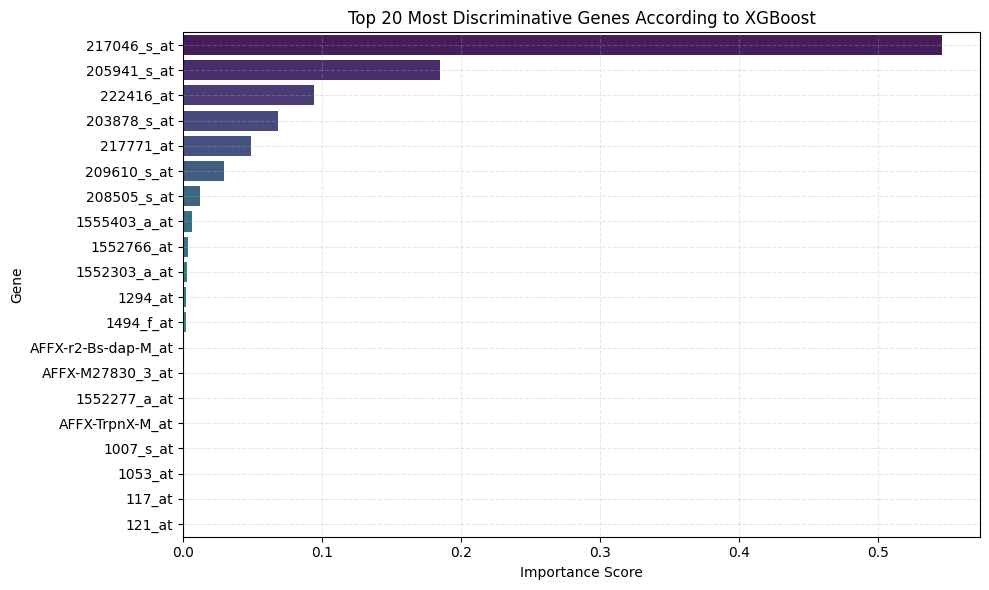

In [24]:
# Extract feature importances
importances = xgb_model.feature_importances_
feature_names = X.columns  # gene names

# Create sorted DataFrame
feat_imp = pd.DataFrame({
    'Gene': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='Importance', y='Gene', palette='viridis')
plt.title("Top 20 Most Discriminative Genes According to XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Gene")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Model Predictions Visualization in PCA Space

In [31]:
# Add predictions to df_pca (on test set only)
df_pca.loc[X_test.index, 'Pred_SVM'] = y_pred_svm  # values 0/1
df_pca.loc[X_test.index, 'Pred_XGB'] = y_pred_xgb 
# Add columns with readable labels for SVM and XGBoost
df_pca['SVM_Label'] = df_pca['Pred_SVM'].map({1: 'Cancer', 0: 'Healthy'}) 
df_pca['XGB_Label'] = df_pca['Pred_XGB'].map({1: 'Cancer', 0: 'Healthy'})


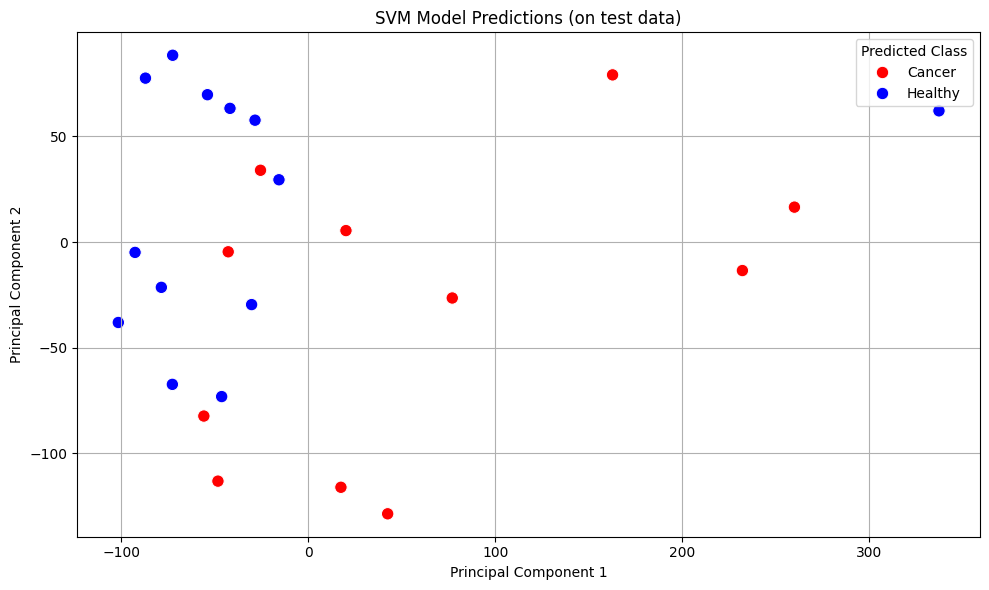

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca.loc[X_test.index],
    x='PC1', y='PC2',
    hue='SVM_Label',
    palette={'Healthy': 'blue', 'Cancer': 'red'},
    s=80
)
plt.title("SVM Model Predictions (on test data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Predicted Class")
plt.grid(True)
plt.tight_layout()
plt.show()


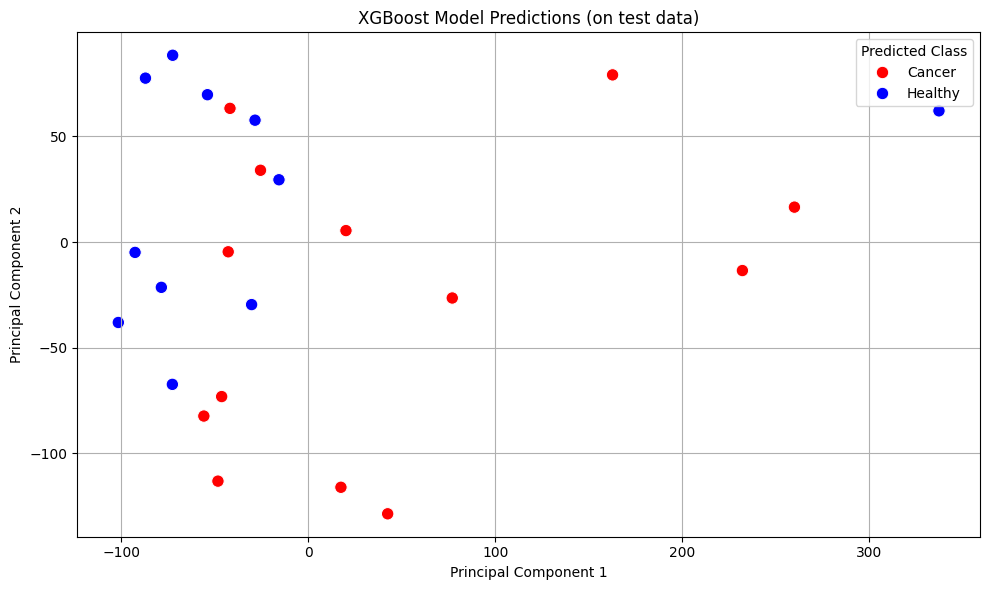

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca.loc[X_test.index],
    x='PC1', y='PC2',
    hue='XGB_Label',
    palette={'Healthy': 'blue', 'Cancer': 'red'},
    s=80
)
plt.title("XGBoost Model Predictions (on test data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Predicted Class")
plt.grid(True)
plt.tight_layout()
plt.show()


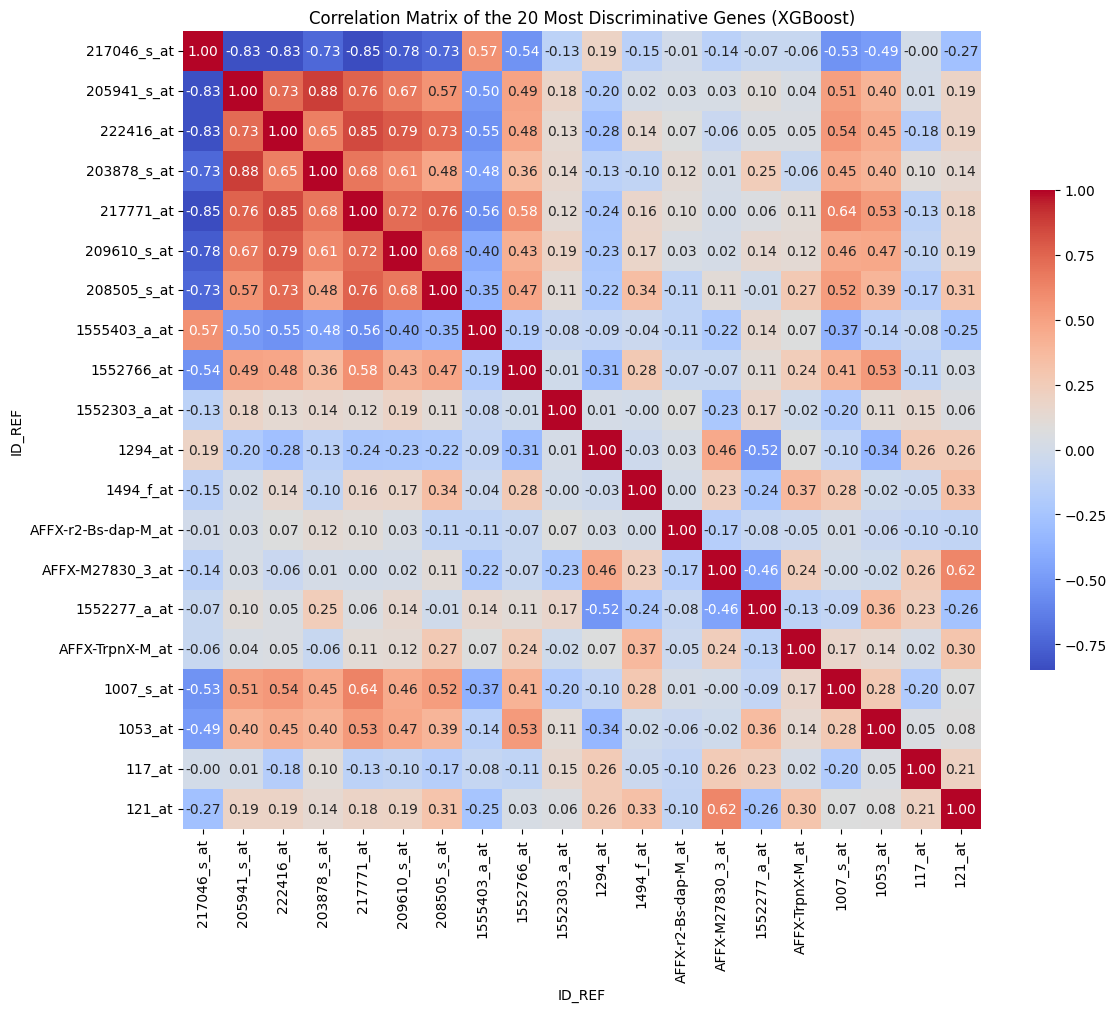

In [34]:
top_genes = feat_imp['Gene'].tolist()[:20]  # top 20 genes

# Extract their columns from df_scaled
X_subset = df_scaled[top_genes]

# Calculate correlation matrix
corr_matrix = X_subset.corr()

# Display with seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .6})
plt.title("Correlation Matrix of the 20 Most Discriminative Genes (XGBoost)")
plt.tight_layout()
plt.show()
